Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

## Задача: 
Добиться максимальной точности модели, которая предсказывает рейтинг отеля, ориентируясь на метрику MAPE.

In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

#импортируем библиотеки для кодирования категориальных признаков:
import category_encoders as ce

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [99]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [100]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [101]:
# Подгрузим наши данные из соревнования

df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

\# Знакомимся с данными

## Первоначальные признаки датасета:

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

In [102]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [103]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [104]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [105]:
df_test.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [106]:
sample_submission.head()

,reviewer_score,id
0,8.541,488440
1,7.745,274649
2,8.765,374688
3,9.680,404352
4,9.646,451596


In [107]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [108]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/var/folders/72/b69zs3rx1vvdfb_qtlhy8szh0000gn/T/ipykernel_22196/447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [109]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


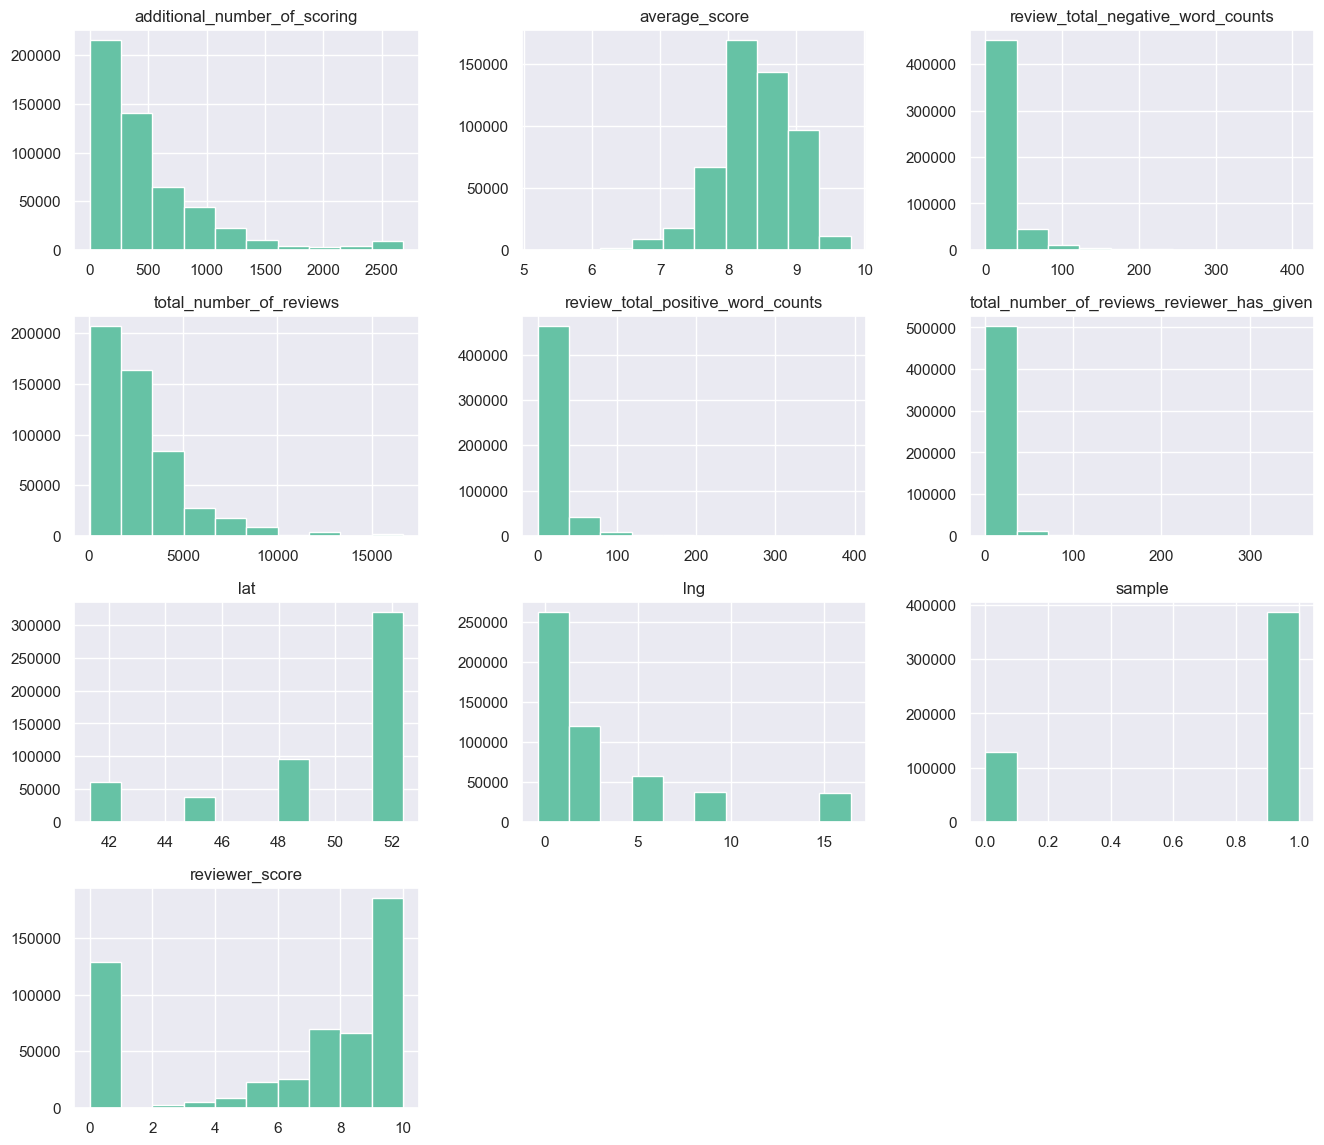

In [110]:
# Для начала построим распеределение всех числовых признаков быстрой простой визуализацией
data.hist(figsize=(16,14));

У всех числовых признаков распределение отличается от нормального.

Text(0.5, 0, 'Оценка')

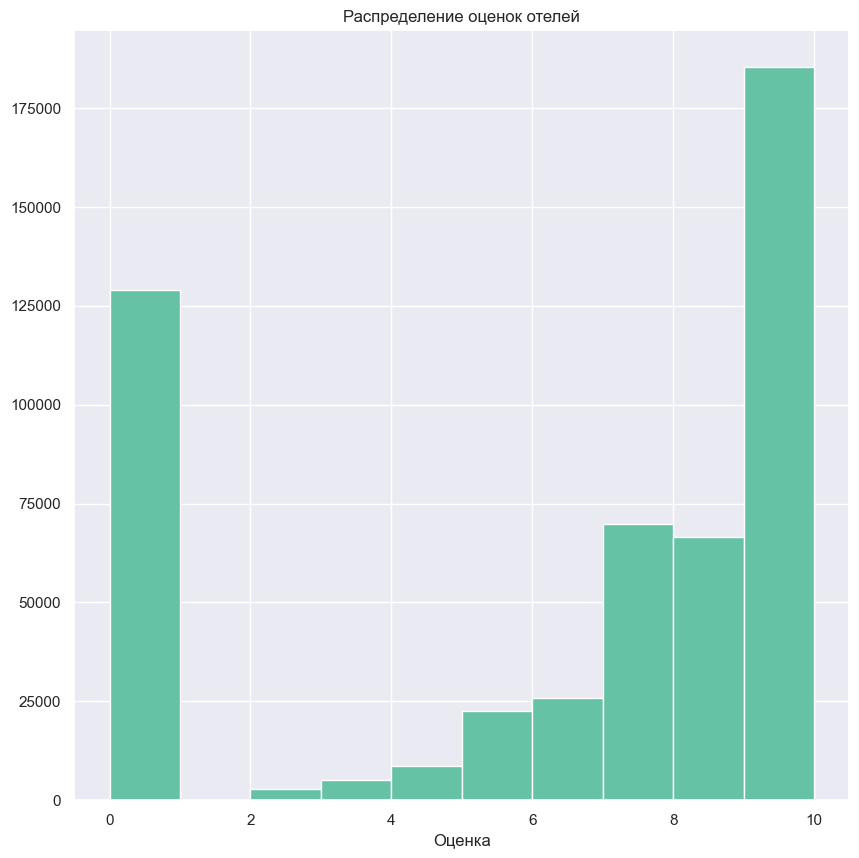

In [111]:
# Посмотрим распределение главного признака.
data['reviewer_score'].hist()
plt.title('Распределение оценок отелей')
plt.xlabel('Оценка')

# Очистка данных

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [113]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


In [114]:
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

Пропуски есть в двух признаках: lat и lng - географическая широта и долгота отеля. Посмотрим к каким отелям и адресам принадлежат пропуски.

In [115]:
empty_row = data[data['lat'].isnull() | data['lng'].isnull()]
hotel_empty = empty_row[['hotel_name', 'hotel_address']]
hotel_empty

,hotel_name,hotel_address
35,Hotel Atlanta,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...
293,Hotel Atlanta,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...
476,City Hotel Deutschmeister,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...
526,Holiday Inn Paris Montmartre,23 Rue Damr mont 18th arr 75018 Paris France
569,Fleming s Selection Hotel Wien City,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...
...,...,...
515027,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...
515400,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...
515439,Maison Albar Hotel Paris Op ra Diamond,4 rue de la P pini re 8th arr 75008 Paris France
515637,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...


In [116]:
# У нас 3268 строк с пропущенными значениями в признаках географических координат. 
# Посмотрим сколько в них уникальных значений
hotel_list= hotel_empty.value_counts()
hotel_list

hotel_name                                        hotel_address                                              
Fleming s Selection Hotel Wien City               Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria    658
Hotel City Central                                Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria            563
Hotel Atlanta                                     W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria       389
Maison Albar Hotel Paris Op ra Diamond            4 rue de la P pini re 8th arr 75008 Paris France               290
Hotel Daniel Vienna                               Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria         245
Hotel Pension Baron am Schottentor                W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria          223
Austria Trend Hotel Schloss Wilhelminenberg Wien  Savoyenstra e 2 16 Ottakring 1160 Vienna Austria               194
Derag Livinghotel Kaiser Franz Joseph Vienna      Sieveringer Stra e 4 

Пропуски надо чем то заменить, самое логичное: координатами нахождения отеля, их список мы уже знаем. У нас всего 17 отелей с пропусками координат, изначально я хотела воспользоваться библиотекой geopy, в плане сетевых запросов kaggle может накладывать ограничения, поэтому в качестве альтернативы выгрузим набор координат и укажим их в виде словаря, а потом восстановить пропуски, используя структуру. 

In [117]:
# формируем словари с данными по долготе и широте
dict_lat = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': '48.21974808057666', 
                'Holiday Inn Paris Montmartre': '48.889064368690235',
                'Fleming s Selection Hotel Wien City': '48.20949471863499',
                'Hotel Atlanta': '48.2209723965124',
                'Maison Albar Hotel Paris Op ra Diamond': '48.87543722920124',
                'Derag Livinghotel Kaiser Franz Joseph Vienna': '48.24608017805536',
                'Hotel City Central': '48.214201786014854',
                'NH Collection Barcelona Podium': '41.39176529029773',
                'City Hotel Deutschmeister': '48.22103057609981',
                'Hotel Daniel Vienna': '48.18897212994251',
                'Roomz Vienna': '48.22382961585223',
                'Hotel Pension Baron am Schottentor': '48.21692824899107',
                'Mercure Paris Gare Montparnasse': '48.84010021974514',
                'Hotel Park Villa': '48.23759024291264',
                'Hotel Advance': '41.38327316014033',
                'Renaissance Barcelona Hotel': '41.394162363243964',
                'Cordial Theaterhotel Wien': '48.20969901650749'}

dict_lng = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': '16.285624283904383', 
                'Holiday Inn Paris Montmartre': '2.333206641604505',
                'Fleming s Selection Hotel Wien City': '16.35350997041095',
                'Hotel Atlanta': '16.356650516337886',
                'Maison Albar Hotel Paris Op ra Diamond': '2.3234027262612256',
                'Derag Livinghotel Kaiser Franz Joseph Vienna': '16.34202545691955',
                'Hotel City Central': '16.379923233140797',
                'NH Collection Barcelona Podium': '2.1783660658934747',
                'City Hotel Deutschmeister': '16.366622226233126',
                'Hotel Daniel Vienna': '16.3838329415743',
                'Roomz Vienna': '16.393969343883455',
                'Hotel Pension Baron am Schottentor': '16.360055901096636',
                'Mercure Paris Gare Montparnasse': '2.3231778953046462',
                'Hotel Park Villa': '16.34703938556462',
                'Hotel Advance': '2.162964217594162',
                'Renaissance Barcelona Hotel': '2.1748749075722924',
                'Cordial Theaterhotel Wien': '16.351495483903957'}

In [118]:
# заполняем пропуски
data['lat'] = data.apply(lambda x: dict_lat.get(x['hotel_name']) if pd.isnull(x['lat']) else x['lat'], axis=1).astype('float64')
data['lng'] = data.apply(lambda x: dict_lng.get(x['hotel_name']) if pd.isnull(x['lng']) else x['lng'], axis=1).astype('float64')

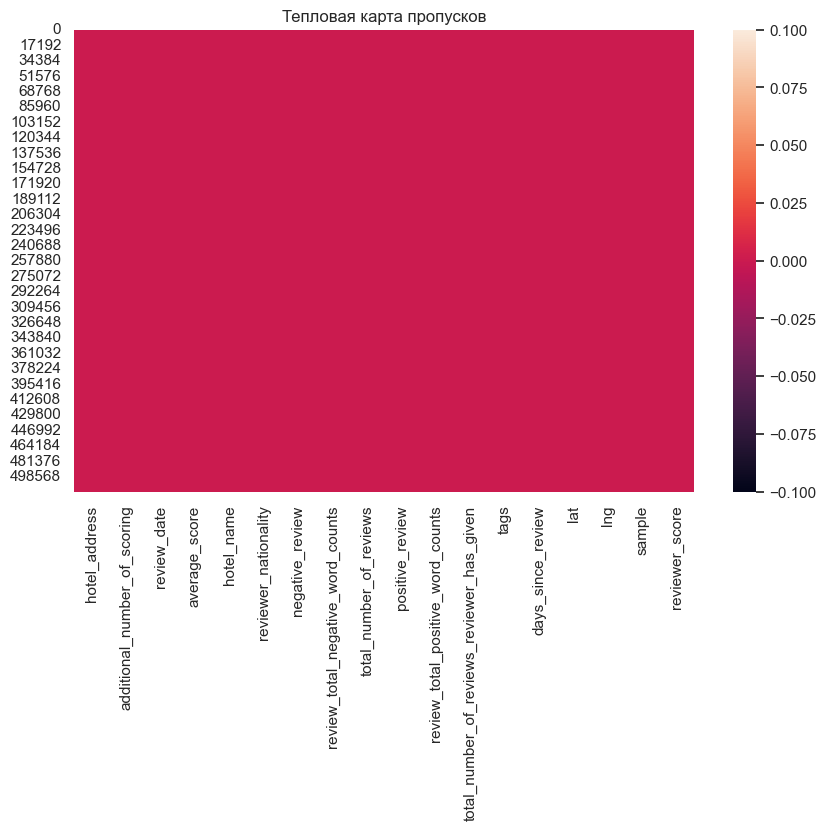

In [119]:
#проверяем остались ли у нас пропущенные значения в признаках
fig = plt.figure(figsize = (10,6))
sns.heatmap(data.isnull())
plt.title('Тепловая карта пропусков')
plt.show()

Пропусков больше нет, можно приступать к следующему этапу: разведывательному анализу, и попробуем извлечь полезную информацию из категориальных признаков 

# Разведывательный анализ. 

## Адрес отеля (hotel_address)

In [120]:
# Создадим признак города из адреса отеля
data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2])# берем второй элемент с конца, который является названием города
data['city'] = data['city'].apply(lambda x: 'London' if x == 'United' else x)

In [121]:
data['city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

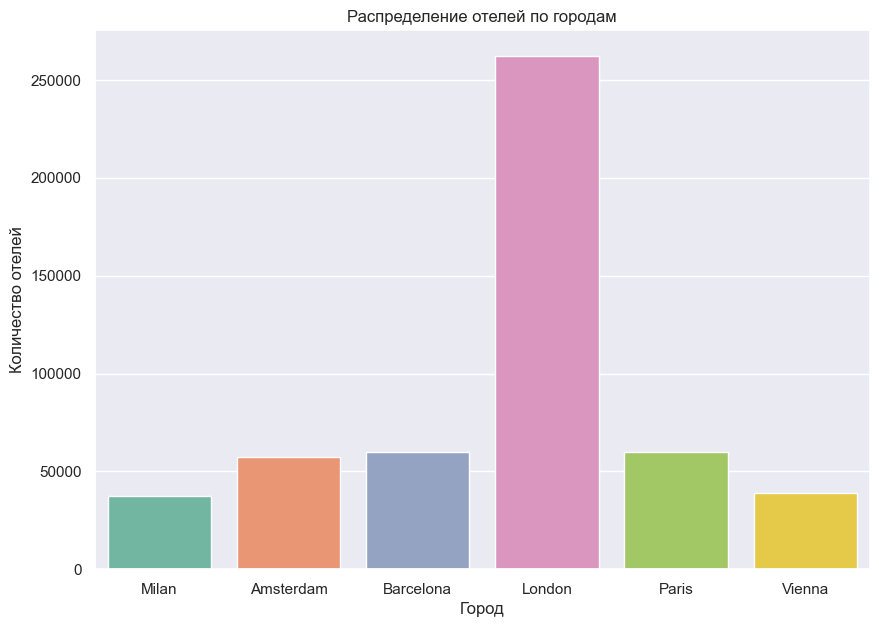

In [122]:
# Построим диаграмму по городам
fig, ax = plt.subplots(figsize=(10, 7))

barplot = sns.countplot(x='city', data=data)

barplot.set_title('Распределение отелей по городам')
barplot.set_xlabel('Город')
barplot.set_ylabel('Количество отелей')
plt.show()

Наш датасет представлен гостиницами Европы, большинство из которых расположены в Лондоне.

In [123]:
# Создадим признак страны также из адреса отеля
data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1])# берем  первый элемент с конца, который является названием города
data['country'] = data['country'].apply(lambda x: 'United Kindom' if x == 'United' else x)

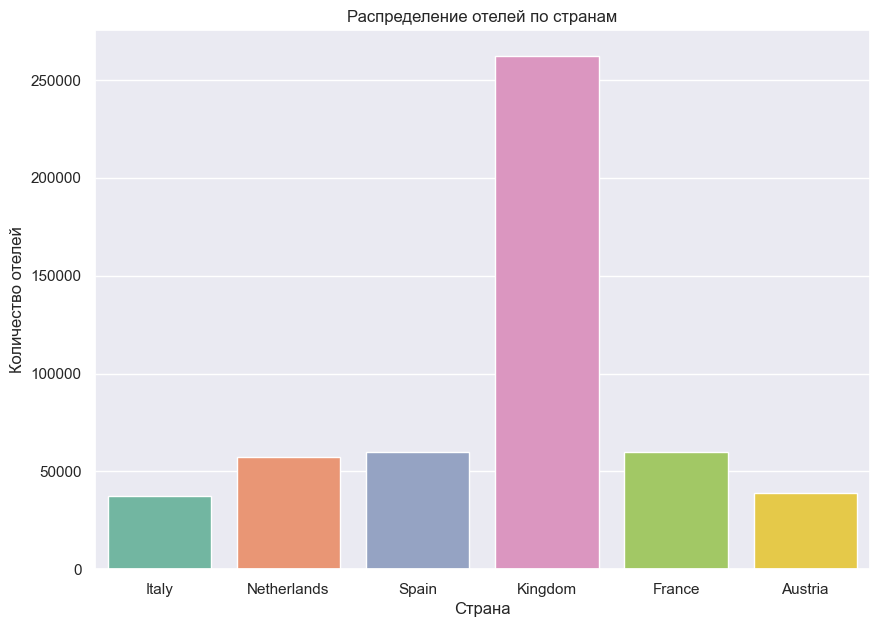

In [124]:
# Построим диаграмму по странам
fig, ax = plt.subplots(figsize=(10, 7))

barplot = sns.countplot(x='country', data=data)

barplot.set_title('Распределение отелей по странам')
barplot.set_xlabel('Страна')
barplot.set_ylabel('Количество отелей')
plt.show()

Расхождения в логике количества отелей по городам и странам нет.

In [125]:
data.groupby(['city', 'country'])['hotel_name'].count()

city       country    
Amsterdam  Netherlands     57214
Barcelona  Spain           60149
London     Kingdom        262301
Milan      Italy           37207
Paris      France          59928
Vienna     Austria         38939
Name: hotel_name, dtype: int64

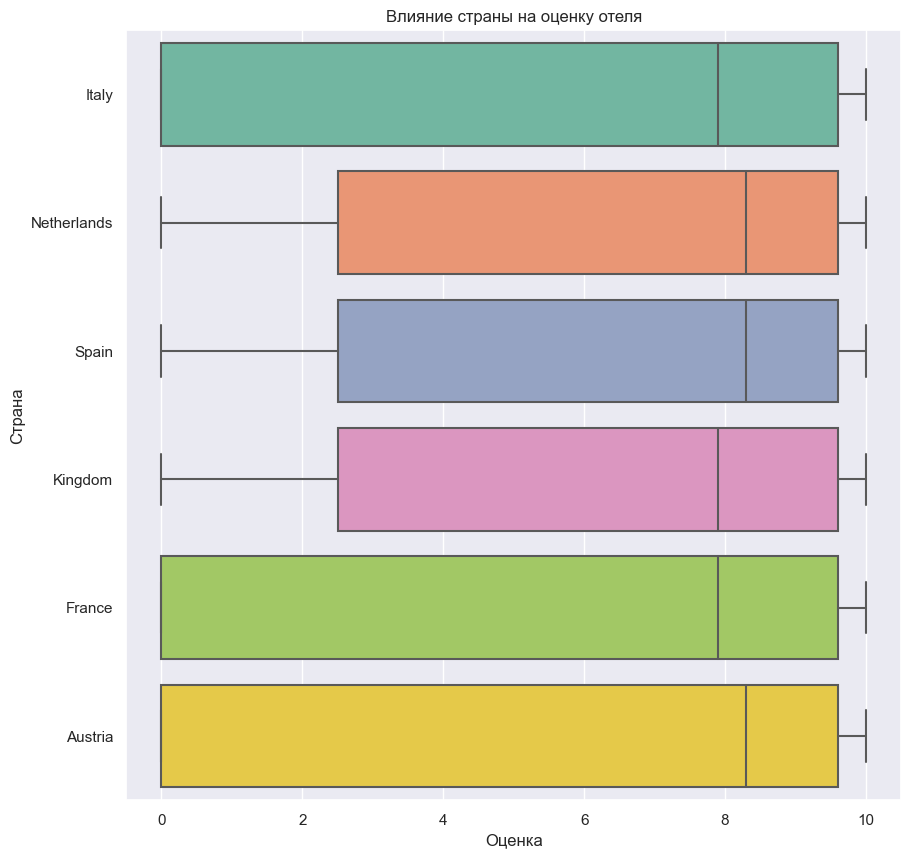

In [126]:
ax = sns.boxplot(
    data= data,
    x = 'reviewer_score',
    y = 'country'
)
ax.set_title('Влияние страны на оценку отеля');
ax.set_xlabel('Оценка')
ax.set_ylabel('Страна');

Видно, что все остели расположены только в 6 странах Европы и представлены шестью городами, по одному городу от каждой страны. Также видно, что такие страны, как Италия, Франция и Англия выставляют примернот одинаковые оценки, имеют одинаковую медиану.

Т к значений немного, сразу закодируем признак city и country, воспользуемся методом онократного кодирования с помощью функции get_dummies().

In [127]:
data = pd.get_dummies(data, columns = ['city'])
data = pd.get_dummies(data, columns = ['country'])

In [128]:
# Осталось удалить исходный признак 
data = data.drop(['hotel_address'], axis=1)

## Дата отзыва (review_date)

Говаря об отзывах, наверника сезонность имеет значение, поэтому поработаем с признаком даты написания отзыва и прежде всего приведем его к нужному формату.

In [129]:
data['review_date'] = pd.to_datetime(data['review_date'])

In [130]:
# С помощью акссесора dt выделим год, месяц и день недели
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month
data['review_day_of_week'] = data['review_date'].dt.dayofweek
data['is_weekend'] = data['review_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['quarter'] = data['review_date'].dt.quarter

In [131]:
data['quarter'].value_counts()

3    142418
2    132269
1    121631
4    119420
Name: quarter, dtype: int64

In [132]:
data['is_weekend'].value_counts()

0    379924
1    135814
Name: is_weekend, dtype: int64

Text(0.5, 0, 'месяц')

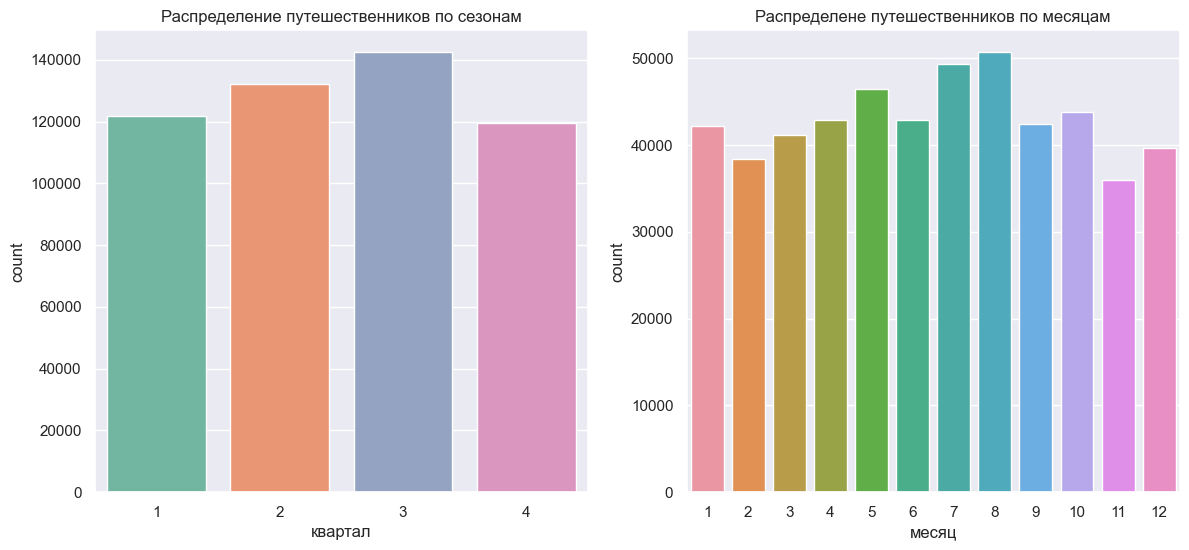

In [133]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,6))
sns.countplot(x='quarter',data=data,ax=ax[0])
ax[0].set_title('Распределение путешественников по сезонам')
ax[0].set_xlabel('квартал')
sns.countplot(x='review_month',data=data,ax=ax[1])
ax[1].set_title('Распределене путешественников по месяцам')
ax[1].set_xlabel('месяц')

quarter
4    6.265140
3    6.265916
2    6.295959
1    6.368658
Name: reviewer_score, dtype: float64

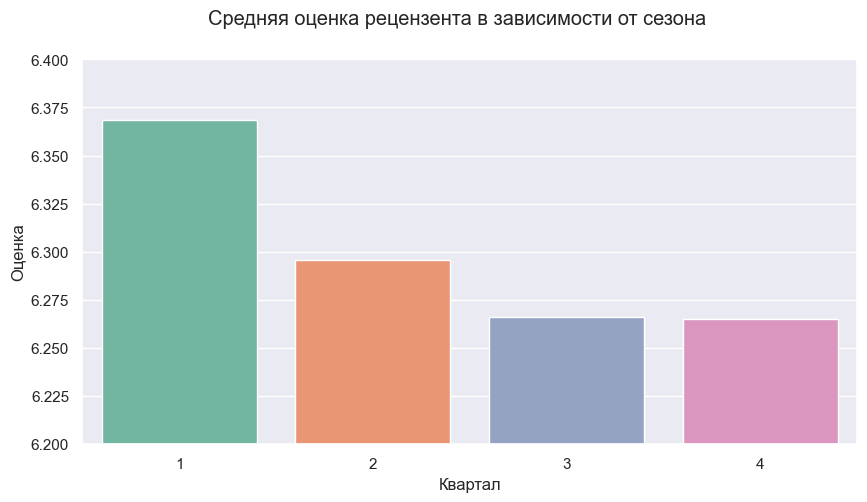

In [134]:
pivot_season = data.groupby('quarter')['reviewer_score'].mean().sort_values()
fig = plt.figure(figsize=(10,5))
season = sns.barplot(
    x=pivot_season.index, 
    y=pivot_season
)
plt.suptitle('Средняя оценка рецензента в зависимости от сезона')
plt.ylim(6.2, 6.4)
plt.xlabel('Квартал')
plt.ylabel('Оценка');

pivot_season

is_weekend
1    6.296089
0    6.298238
Name: reviewer_score, dtype: float64

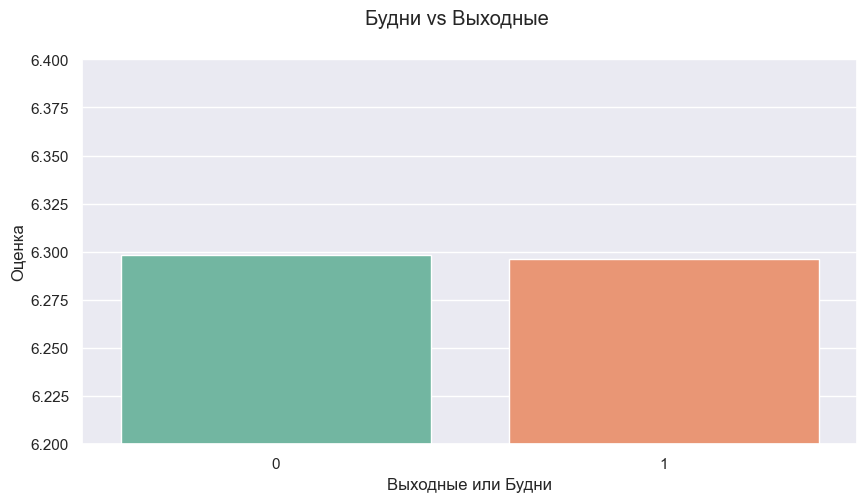

In [135]:
pivot_weekend = data.groupby('is_weekend')['reviewer_score'].mean().sort_values()
fig = plt.figure(figsize=(10,5))
season = sns.barplot(
    x=pivot_weekend.index, 
    y=pivot_weekend
)
plt.suptitle('Будни vs Выходные')
plt.ylim(6.2, 6.4)
plt.xlabel('Выходные или Будни')
plt.ylabel('Оценка');
pivot_weekend

review_day_of_week
3    6.258057
4    6.258730
0    6.282099
5    6.285409
2    6.294204
6    6.302680
1    6.350384
Name: reviewer_score, dtype: float64

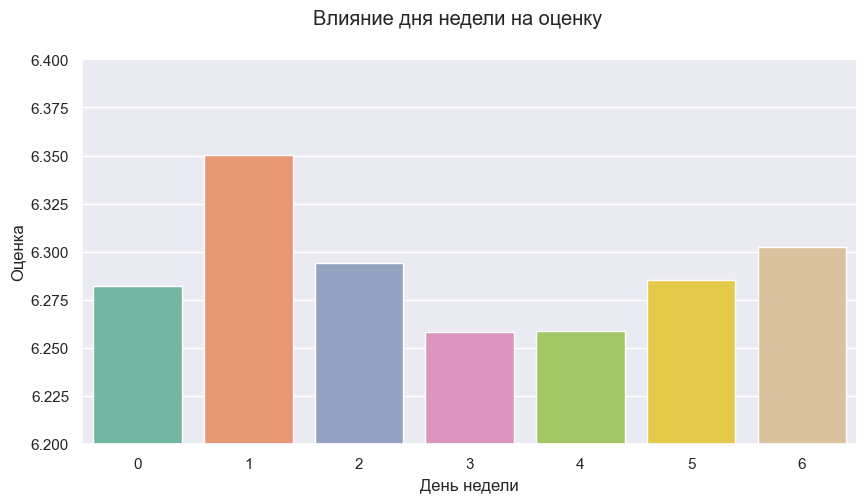

In [136]:
pivot_weekday = data.groupby('review_day_of_week')['reviewer_score'].mean().sort_values()
fig = plt.figure(figsize=(10,5))
season = sns.barplot(
    x=pivot_weekday.index, 
    y=pivot_weekday
)
plt.suptitle('Влияние дня недели на оценку')
plt.ylim(6.2, 6.4)
plt.xlabel('День недели')
plt.ylabel('Оценка');

pivot_weekday

In [137]:
# Удалим исходный столбец
data = data.drop('review_date', axis=1) 

Больше всего отзывов приходится на третий квартал, т е на летние месяцы: июнь, июль, август, а также на будние дни. При этом средняя оценка сильно от сезона к сезону не отличается, так же, как нет особой разницы, является ли день оставления отзыва будним или выходным (интересно, что самый высокий средний отзыв оставляют в понедельник. Возможно это связано с тем, что на выходный большой наплыв отдыхающих, а вот в понельник уже можно спокойно отдохнуть от суеты и шума). Из этого наблюдения можем сделать предварительный вывод о том, что признак времени (дата) не является значимым.

## Признак reviewer_nationality

Посмотрим число уникальных значений данного признака

In [138]:
data['reviewer_nationality'].value_counts()

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

В данном наборе данных представлены отзывы туристов из 227 стран, большинство из которых из стран Европы. Смысла нет кодировать все значения признака их очень много, к тому же вряд ли сильное влияние на общую картину имеет единственый представитель своей страны. Плюс тут может быть как раз искажение общих данных, потому что здесь может быть как субъективная положительная оценка неискушенного туриста, так и несправедливая негативная оценка из-за культурных или религиозных отличий. Поэтому возмем 30 самым популярных. 

In [139]:
# составим топ-30 национальностей по количеству отзывов
top_nationality = data['reviewer_nationality'].value_counts().nlargest(30).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x:x if x in top_nationality else 'other' )
data['reviewer_nationality'].value_counts()

 United Kingdom               245246
other                          61634
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
 India                          3437
 Greece                         3406
 China                          3400
 Sweden                         3368
 New Zealand                    3237
 Singapore                      3091
 

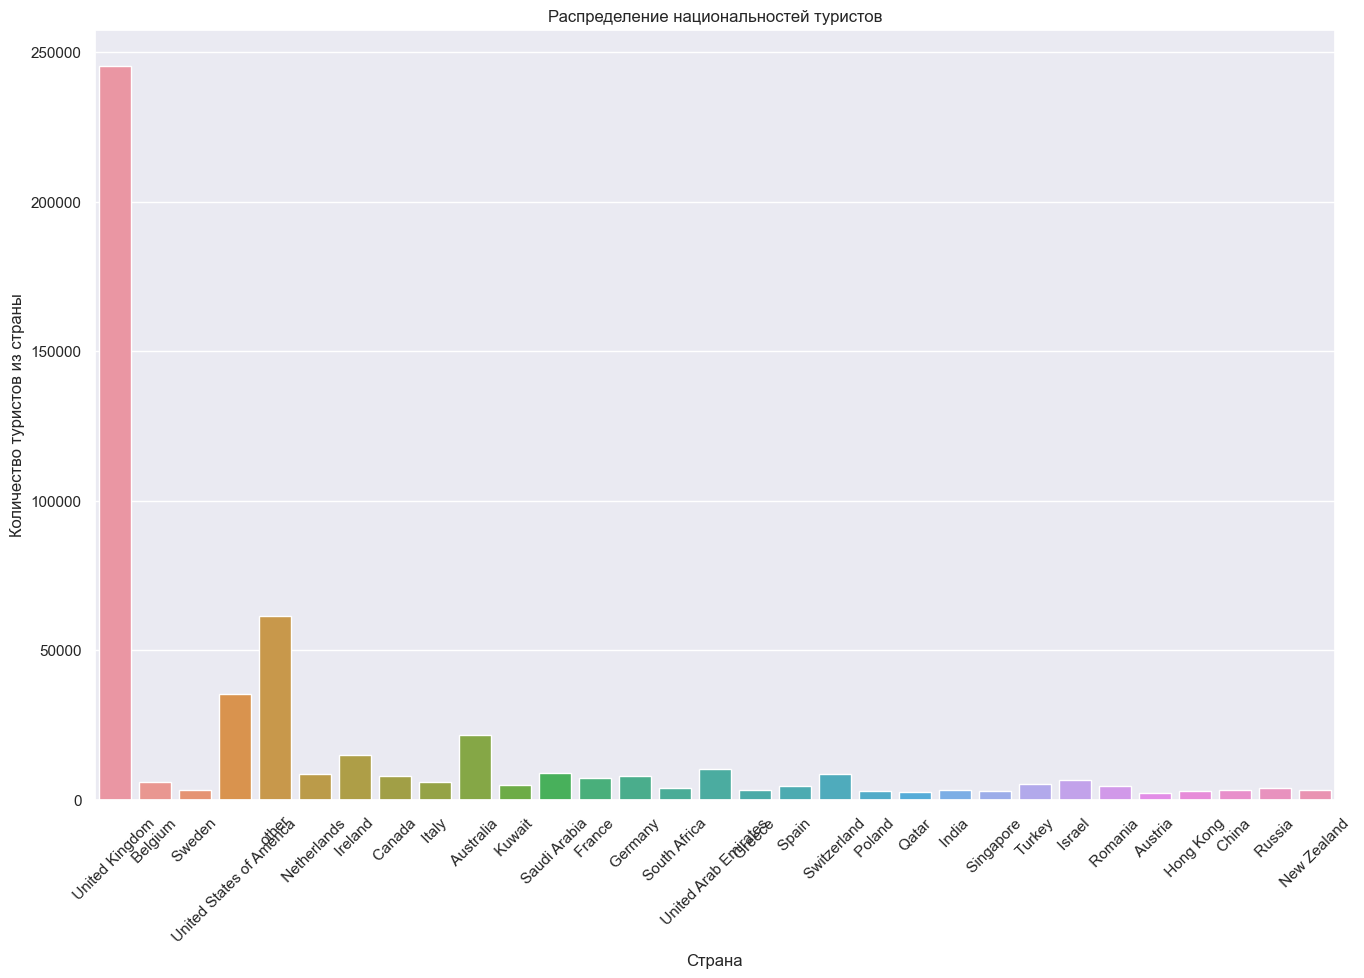

In [140]:
fig = plt.figure(figsize = (16,10))
barplot = sns.countplot(x='reviewer_nationality', data=data)
barplot.set_title('Распределение национальностей туристов')
barplot.set_xlabel('Страна')
barplot.set_ylabel('Количество туристов из страны')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45)
plt.show()

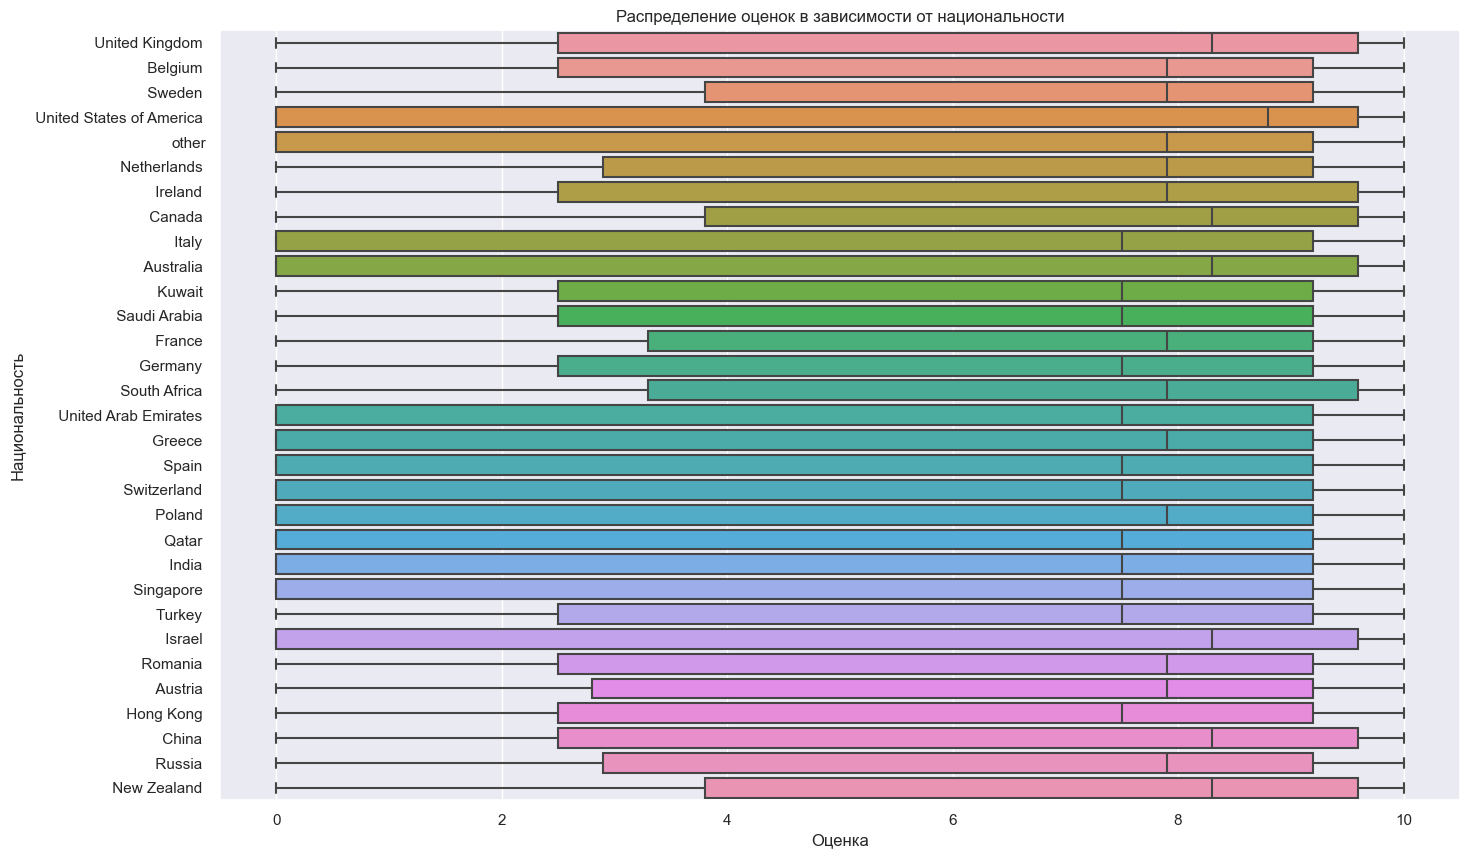

In [141]:
#Посмотрим еще один график распределения оценки взависимости от национальности
fig = plt.figure(figsize = (16,10))
barplot = sns.boxplot(data=data,
                      x = 'reviewer_score',
                      y = 'reviewer_nationality',
                      orient ='h',
                     )
barplot.set_title('Распределение оценок в зависимости от национальности')
barplot.set_xlabel('Оценка')
barplot.set_ylabel('Национальность')
plt.show()

Мы видим, что у некоторых стран таких, как Италия, ЮАЭ, Швеция, Индия и др, разброс оценок очень велик, при этом значения медиан у таких стран очень близки, из чего можно предположить, что несмотря на культурные различия, туристы из этих страны предъявляют одинаковые требования к отелю и сервису, и одинаково негативно реагируют на то, что им не нравится.

В наборе данных есть числовой признак total_number_of_reviews_reviewer_has_given, расчитаем сколько в среднем туристы давали отзывов в прошлом. Для этого сгруппируем данные по рецензистам и посмотрим среднее количество отзывов по ним. А затем создадим новый признак "среднее количество отзывов на человека".

In [142]:
average_reviews = data.groupby('reviewer_nationality')['total_number_of_reviews_reviewer_has_given'].mean()
data['average_reviews'] = data['reviewer_nationality'].map(average_reviews)
print("Средняя оценка: ", data['average_reviews'].mean())
print("Минимальная оценка: ", data['average_reviews'].min())
print("Максимальная оценка: ",data['average_reviews'].max())

Средняя оценка:  7.1660009539727545
Минимальная оценка:  5.173299462580429
Максимальная оценка:  15.070909719820131


In [143]:
# Наконец, закодируем новые признаки, так как их мы создали больше 15, воспользуемся методом бинарного кодирования
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [144]:
#Удаляем исходный признак
data = data.drop(['reviewer_nationality'], axis=1)

## Признак tags 

Попробуем извлечь из этого информативного категориального признака как можно больше полезной информации.

In [145]:
# Разделим строки с тегами на отдельные составляющие. Сделаем список тегов посмотрим и сколько в нем уникальных значений.
def rev_func(str_tags):
    str_tags=str_tags[2:-2]
    list_tags=str_tags.strip().split('\',\' ')
    return list_tags
data['tags_split']=data['tags'].apply(rev_func)
data=data.explode('tags_split')
len(data['tags_split'].unique())

55242

Каждое значение нового признака tags_split содержит много полезной информации, например, была это деловая или туристическая поездка, количество проведенных ночей, категория номера в отеля и прочее. Для начала более детально ознакомимся с данными.

In [146]:
data['tags_split'][:30].value_counts()

Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights                                                                   1
Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night                                                                     1
Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 2 nights                                                          1
Leisure trip ', ' Solo traveler ', ' Luxury Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device                  1
Leisure trip ', ' Family with older children ', ' Standard Twin Room ', ' Stayed 3 nights ', ' Submitted from a mobile device    1
Leisure trip ', ' Couple ', ' Classic Room ', ' Stayed 5 nights                                                                  1
Leisure trip ', ' Couple ', ' Club Double Room ', ' Stayed 1 night                                                               1
Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a

In [147]:
# А теперь попробуем достать всю необходимую информацию и создадим новые числовые признаки. 
tag = data['tags_split']

#Вид поездки
def get_trip(tags):
    if 'Leisure trip' in tags:
        return 1
    if 'Business trip' in tags:
        return 2
    return 3
data['trip_type']=tag.apply(get_trip)   

#Количество путешественников
def get_number_of_traveler(tags):
    if 'Solo traveler' in tags:
        return 1
    if 'Couple' in tags:
        return 2
    if 'Group' in tags:
        return 3
    if 'Family with older children' in tags:
        return 4
    if 'Family with young children' in tags:
        return 5
    return 6
data['traveler_type']=tag.apply(get_number_of_traveler)
#При создании признака traveler_type возникли некоторые сложности потому, что я так и не нашла, 
#какое количество туристов возвражает 6 (их количество невелико, всего 2143 значения, поэтому воспринимаем это, как данность).

#Считаем количество ночей
def get_night(tags):
    if 'Stayed 1 night' in tags:
        return 1
    if 'Stayed 2 nights' in tags:
        return 2
    if 'Stayed 3 nights' in tags:
        return 3
    if 'Stayed 4 nights' in tags:
        return 4
    if 'Stayed 5 nights' in tags:
        return 5
    if 'Stayed 6 nights' in tags:
        return 6
    if 'Stayed 7 nights' in tags:
        return 7
    return 0
data['count_night']=tag.apply(get_night)

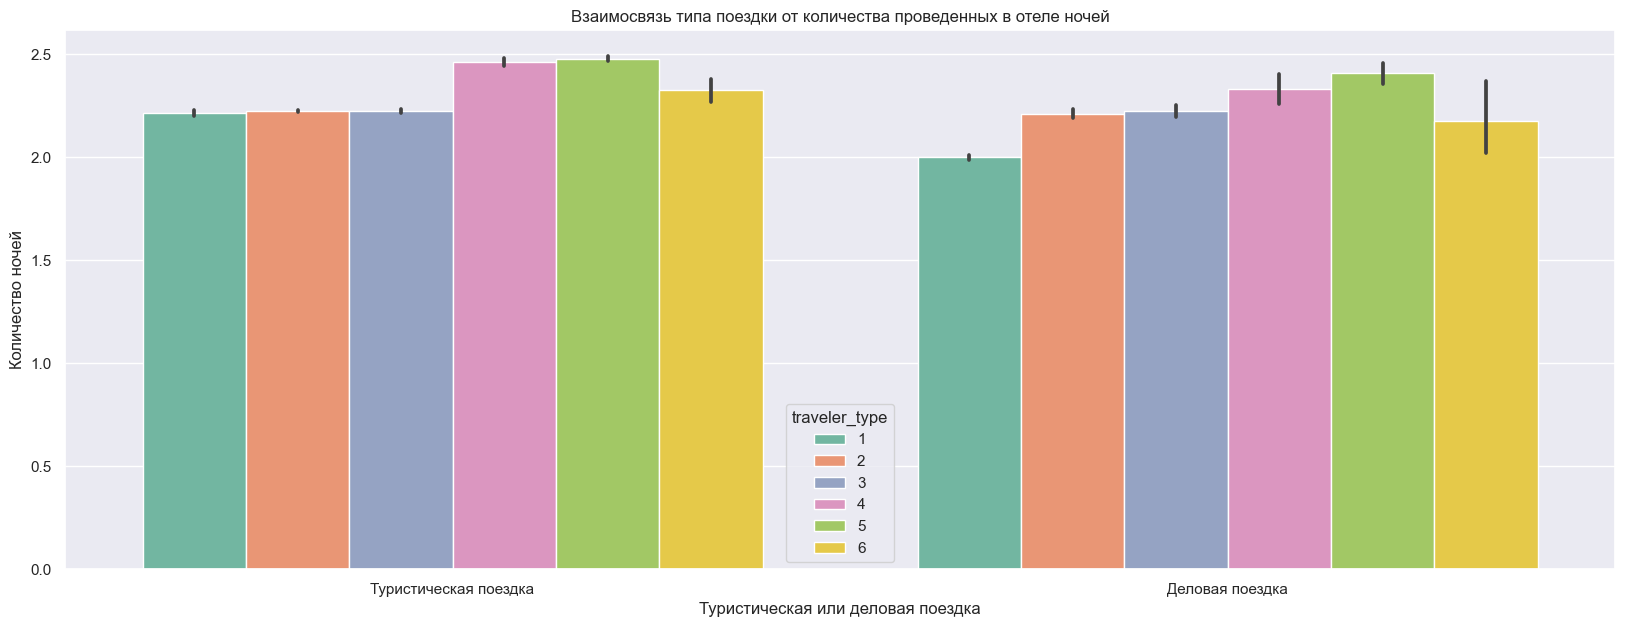

In [148]:
type = data['trip_type']
data['trip_type']= type.apply(lambda x: 'Туристическая поездка' if x == 1 else 'Деловая поездка')
plt.figure(figsize=(20, 7))
sns.barplot(data=data,
             x='trip_type',
             y='count_night',
             hue='traveler_type'
             )   
plt.title('Взаимосвязь типа поездки от количества проведенных в отеле ночей');
plt.xlabel('Туристическая или деловая поездка');
plt.ylabel('Количество ночей');

На графике мы видим, что в основном рецензисты провели в отелях от 2 до 3 ночей, большинство из которых это семьи с детьми, отсюда можно предположить какой сервис и услуги в отелях самые востребованные. Другое дело, что очень удивительно, что для деловых поездок также характерна значительная доля: семья с детьми, что наталкивает на мысль, что либо при оставлении отзыва туристы не придают особого значения, как заполняется отзыв, либо достоверность самих отзывов отставляет желать лучшего.

In [149]:
data.pivot_table(
    values = "traveler_type",
    index = "trip_type",
    columns = "count_night",
    aggfunc = "count"
    )

count_night,0,1,2,3,4,5,6,7
trip_type,,,,,,,,
Деловая поездка,1505,45499,21996,13490,7660,4182,2251,1377
Туристическая поездка,4993,148146,111941,82331,40157,16663,7525,6022


Здесь картина уже более правдоподобная. Видно, что при деловой поездке рецензисты остаются в отеле в основном на 1-2 ночи, что логично, тоже самое характерно и для туристов, которые скорее всего проводят свой weekend, отдыхая в отеле.

traveler_type
1    6.086587
5    6.238669
3    6.341274
4    6.343387
2    6.385186
6    6.473682
Name: reviewer_score, dtype: float64

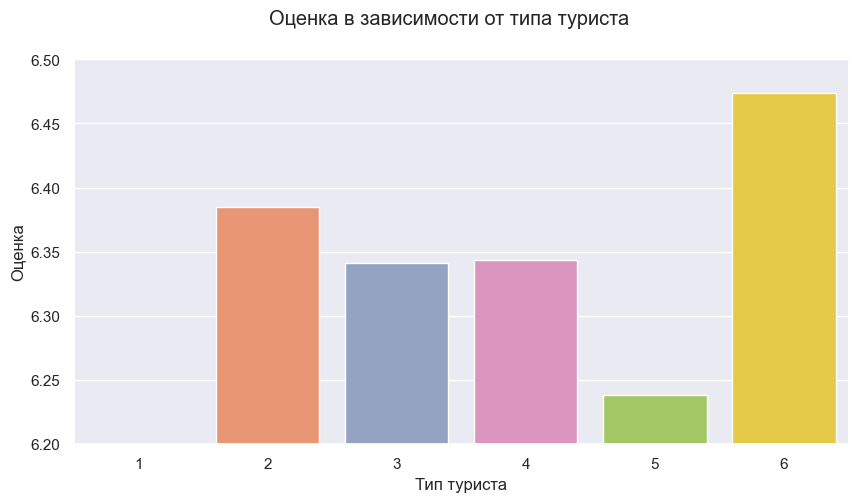

In [150]:
pivot_traveler_type = data.groupby('traveler_type')['reviewer_score'].mean().sort_values()
fig = plt.figure(figsize=(10,5))
season = sns.barplot(
    x=pivot_traveler_type.index, 
    y=pivot_traveler_type
)
plt.suptitle('Оценка в зависимости от типа туриста')
plt.ylim(6.2, 6.5)
plt.xlabel('Тип туриста')
plt.ylabel('Оценка');

pivot_traveler_type

Самую низкую оценку отели получили от семей с маленькими детьми, и причин для этого несколько, как минимум, две самые очевидные: высокие требованию к уровню комфорта и натянутые нервы родителей). 
И вторая интересность: тот, кто путешествует в одиночестве, не склонен оставлять отзывы.

В признаке tags содержится информация о том, было ли отправлено подтверждение с мобильного телефона, что на мой взгляд не особо информативно, а также информация о категории номера, но их несметное множество, поэтому я не стала выделять данную информацию в отдельный признак.
Осталось только удалить исходный признак tags и tags_split.

In [151]:
# Вернем к нужному формату признак trip_type
data['trip_type']=tag.apply(get_trip)
#Удаляем исходный признак tags и tags_split
data = data.drop(['tags', 'tags_split'], axis=1) 

## Признак days_since_review

Здесь не будем мудрить, уберем не нужное, оставим только числовое значение признака и приведем к нужному типу

In [152]:
data['days_since_review']=data['days_since_review'].str.split().str[0]
data['days_since_review']=data['days_since_review'].astype('int')

## Признаки: положительные и отрицательные отзывы (negative_review, positive_review)

У нас есть столбцы с количеством слов в положительном и отрицательном отзывах. Я рассуждаю так: если слов больше в положительном отзыве, чем в негативном, значит отзыв в целом со знаком плюс, т е положительный. Создадим новый признак преобладания эмоций и посмотрим, каких отзывов больше.

In [153]:
data['positive_or_negative'] = data.apply(lambda x: 1 if x['review_total_positive_word_counts'] >= x['review_total_negative_word_counts'] else 0, axis=1)
data['positive_or_negative'].value_counts()

1    287441
0    228297
Name: positive_or_negative, dtype: int64

С небольшим отрывом положительных отзывов больше. 
Теперь перейдем к самым "эмоциональным" признакам, непосредственно к самим отзывам. Понятно, что все рецензисты индивидуальны и по разному выражают свои эмоции, но попробуем посмотреть есть ли что то общее в отзывах, для этого создадим список популярных слов, предварительно разделив отзыв по словам и удалив все ненужные знаки.

Теперь воспользуемся очень интересной библиотекой интерпретация и классификация эмоций - SentimentIntensityAnalyzer
Анализ тональности - это метод анализа текста, который определяет полярность (например, положительное или отрицательное мнение) в тексте.

In [154]:
# Импортируем библиотеку и не забываем включить в настойках Интернет) 
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# создаем инструмент для определния тональности
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/darazvonareva/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [155]:
# создаем признаки, которые принимают значения в виде словаря с оценками тональности
# на негатив, нейтральность, позитив и обобщенный коэфициент
data['score_negative'] = data['negative_review'].apply(lambda x: sid.polarity_scores(x))
data['score_positive'] = data['positive_review'].apply(lambda x: sid.polarity_scores(x))

In [156]:
data['score_negative'].head()

0    {'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...
1    {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...
2    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
4    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
Name: score_negative, dtype: object

In [157]:
data['score_positive'].head()

0    {'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...
1    {'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...
2    {'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...
3    {'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...
4    {'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...
Name: score_positive, dtype: object

In [158]:
#Выделим в отдельный признак обобщающий коэффициент 
data['compound_pos'] = data['score_positive'].apply(lambda score_dict: score_dict['compound'])

In [159]:
data['compound_neg'] = data['score_negative'].apply(lambda score_dict: score_dict['compound'])

Давайте посмотри насколько проставленные с помощью специальной библиотеки оценки соотносятся с реальными отзывами. Для этого посмотри на сам отзыв и на его оценку.

In [160]:
data[['positive_review','negative_review','compound_pos', 'compound_neg']].iloc[15:25]

,positive_review,negative_review,compound_pos,compound_neg
15,I loved everything about the place The locati...,No Negative,0.9603,-0.7096
16,Locate ideal clean facility,1 Bed was faulty seemed to dip in the middle ...,0.7269,-0.8817
17,Breakfast buffet,No Negative,0.0000,-0.7096
18,Location,Very noisy room close to an extrrnal electric...,0.0000,-0.6997
19,All the hotel facilities were great 10 minute...,No Negative,0.7906,-0.7096
20,The Location and the view Close to the Duomo ...,Room rate a bit expensive Breakfast included ...,0.6597,-0.1027
21,Location Culture bars and restaurants Transpo...,Nothing to dislike,0.0000,0.2924
22,Staff were very helpful food was lovely and e...,I wouldn t say it was a 5 star hotel but a ve...,0.9184,0.6474
23,Good location for Camden Lock and market woul...,No Negative,0.4215,-0.7096
24,What a lovely hotel The welcome was fantastic...,No Negative,0.9929,-0.7096


Есть конечно некоторые вопросы к проставленной оценке, но посмотрим к чему нас это приведет. Зато вместо строковых признаков у нас имеются числовые, осталось удалить исходные признаки negative_review и positive_review.

In [161]:
data = data.drop(['negative_review', 'positive_review'], axis=1)

## Признак название отеля(hotel_name)

In [162]:
data['hotel_name'].nunique()

1492

In [163]:
#Очень много уникальных значений, можно их конечно закодировать, но смысла в этом особого не вижу, поэтому пожалуй удалим этот признак
data = data.drop(['hotel_name'], axis=1)

# Отбор признаков 

Для удобства выделим категориальные и числовые признаки

In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [165]:
#Удаляем лишнее 
data = data.drop(['score_negative','score_positive'], axis=1)

In [166]:
data.nunique()

additional_number_of_scoring                    480
average_score                                    34
review_total_negative_word_counts               402
total_number_of_reviews                        1142
review_total_positive_word_counts               365
total_number_of_reviews_reviewer_has_given      198
days_since_review                               731
lat                                            1489
lng                                            1489
sample                                            2
reviewer_score                                   38
city_Amsterdam                                    2
city_Barcelona                                    2
city_London                                       2
city_Milan                                        2
city_Paris                                        2
city_Vienna                                       2
country_Austria                                   2
country_France                                    2
country_Ital

In [167]:
# В расчет не берем целевую переменную reviewer_score и sample - разделитель на тест и трэйн.

# непрерывные признаки
num_cols = ['additional_number_of_scoring', 
                   'review_total_negative_word_counts', 
                   'total_number_of_reviews',
                   'review_total_positive_word_counts',  
                   'total_number_of_reviews_reviewer_has_given',
                   'days_since_review',
                   'average_reviews',
                   'compound_pos', 'compound_neg']

# категориальные признаки
cat_cols = ['average_score', 
            'lat','lng',
            'city_Amsterdam',
            'city_Barcelona',
            'city_London',
            'city_Milan',
            'city_Paris',
            'city_Vienna',
            'country_Austria',
            'country_France',
            'country_Italy',
            'country_Kingdom',
            'country_Netherlands',
            'country_Spain',
            'review_year', 'review_month', 'review_day_of_week', 'is_weekend', 'quarter',
            'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_4',
            'trip_type', 'traveler_type', 'count_night',
            'positive_or_negative']

## Анализ мультиколлинеарности

После разделения признаков, постороим матрицу корреляции. Т к мы уже знаем, что все числовые признаки имеют распределение, отличное от нормального, поэтому будем использовать метод Спирмена.

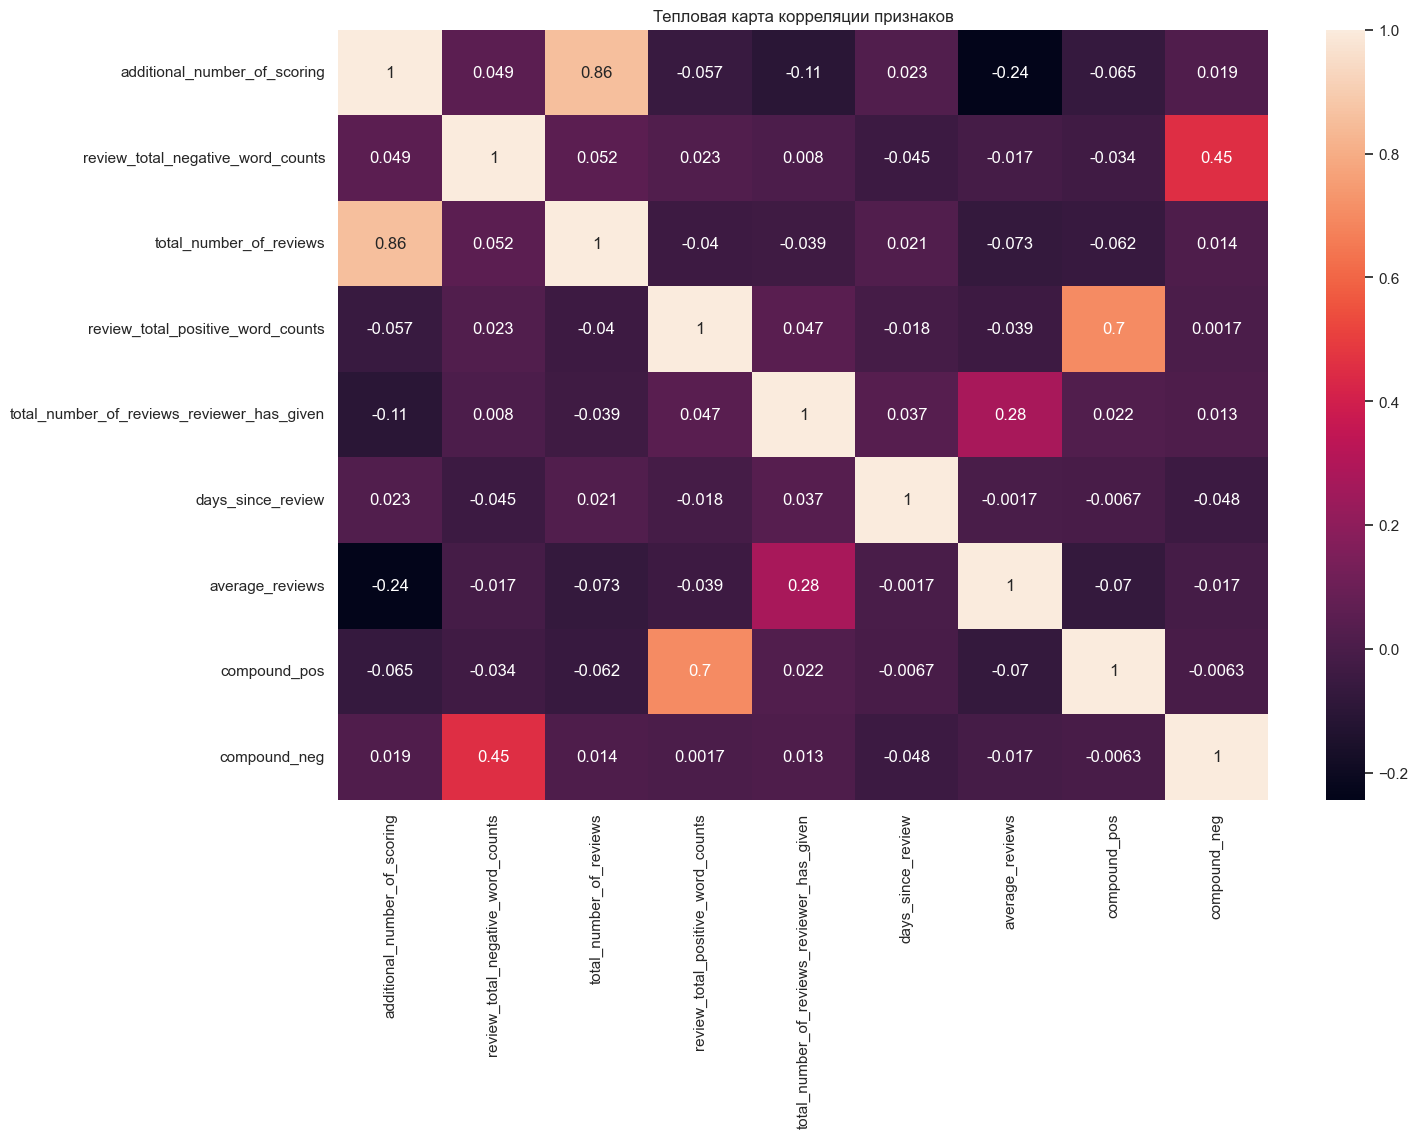

In [168]:
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.heatmap(
    data[num_cols].corr(method='spearman'),
    annot = True
)
ax.set_title('Тепловая карта корреляции признаков');

Чтобы дальше посторить модель, необходимо удалить признаки с очень сильной корреляции

In [169]:
data = data.drop(['total_number_of_reviews','review_total_positive_word_counts'], axis=1)

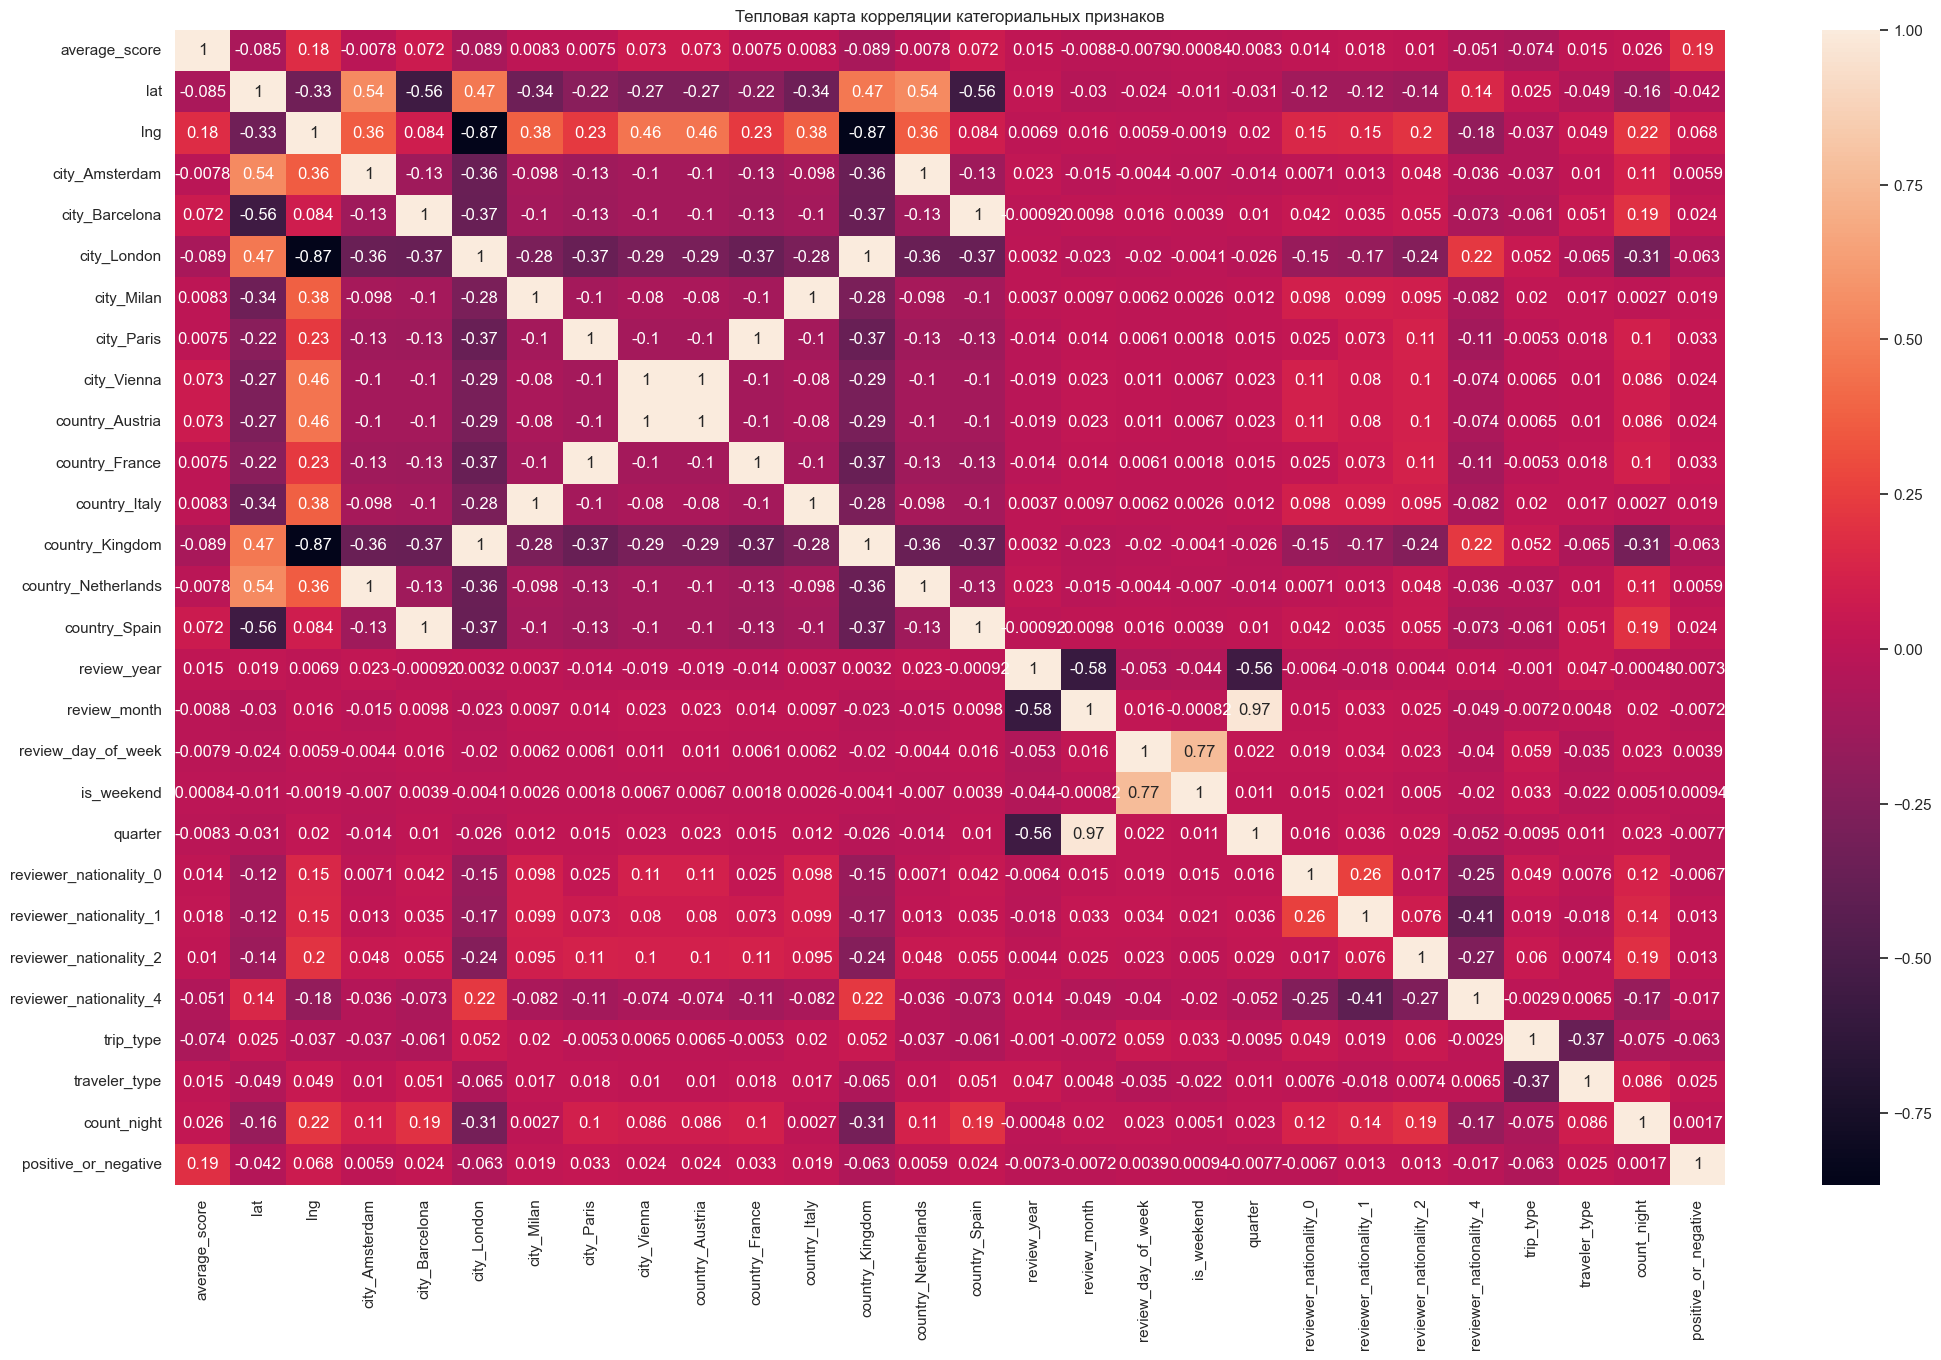

In [170]:
plt.rcParams['figure.figsize'] = (25,15)
ax = sns.heatmap(
    data[cat_cols].corr(method='spearman'),
    annot = True
)
ax.set_title('Тепловая карта корреляции категориальных признаков');

In [171]:
data = data.drop(['lng','quarter', 'is_weekend'], axis=1)

In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   days_since_review                           515738 non-null  int64  
 5   lat                                         515738 non-null  float64
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   city_Amsterdam                              515738 non-null  uint8  
 9   city_Barcelona                              515738 non-null  uint8  
 

## Оценка значимости признаков
Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике.

In [173]:
# разбиваем датасет на части, необходимые для оценки признаков
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X = data.drop(['reviewer_score'], axis = 1)
y = data['reviewer_score'].astype('int')

In [174]:
#Не забудем предварительно удалить из списка категориалных признаков ранее удаленные после анализа мультиколлинеарности. 
cat_cols.remove('lng')
cat_cols.remove('quarter')
cat_cols.remove('is_weekend')

<AxesSubplot: >

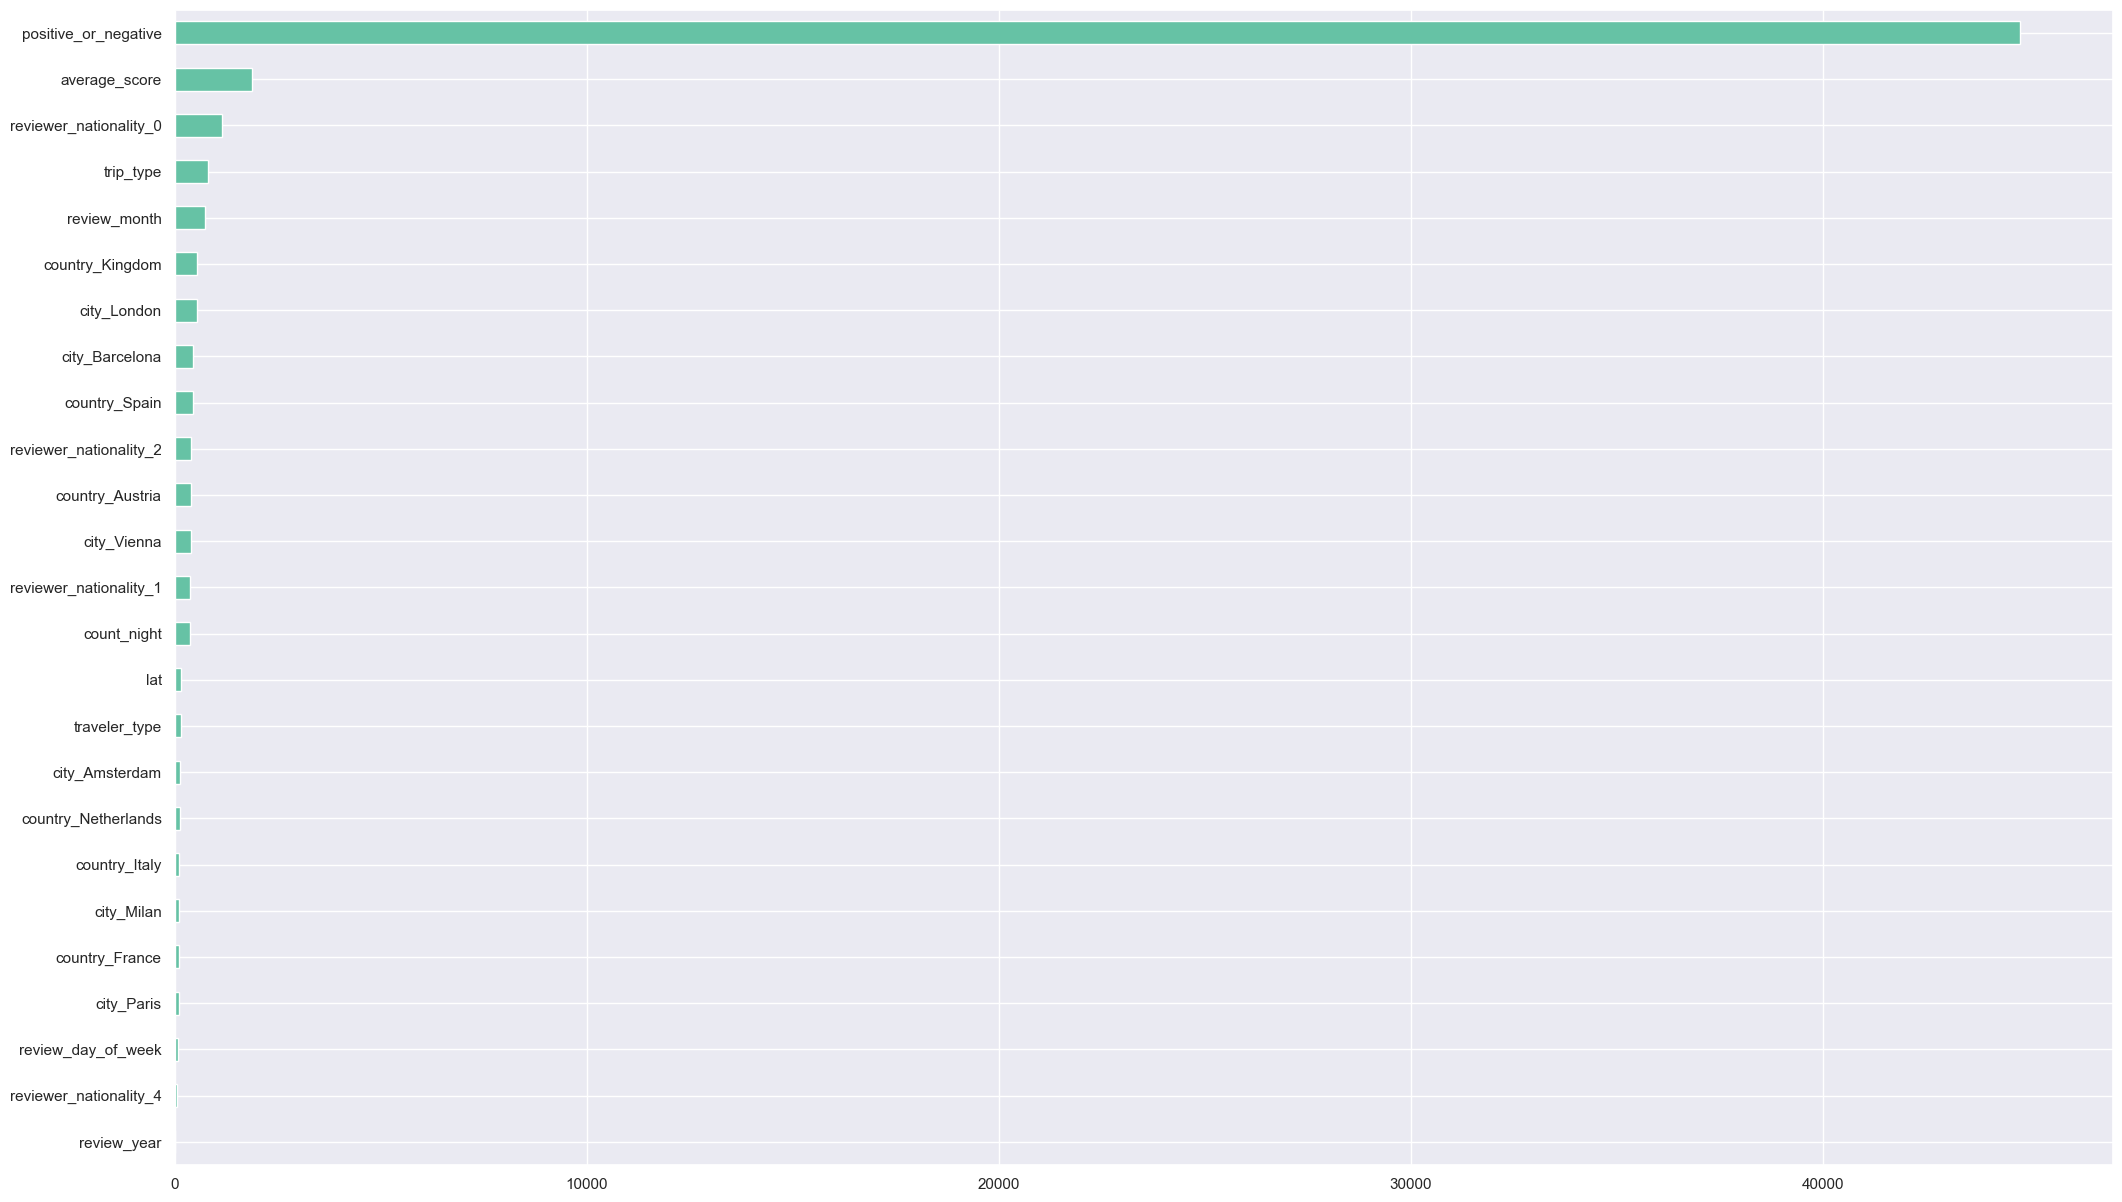

In [175]:
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

По  графику важности категориальных переменных мы можем понять, что признак positive_or_negative оказывает наибольшее влияние на итоговую оценку, при этом часть признаков не несет существенной значимости в определении рейтинга отеля. Удалим их.

In [176]:
cols_del = ['review_year',
            'reviewer_nationality_4',
            'review_day_of_week',
            'city_Paris',
            'country_France',
            'city_Milan',
            'country_Italy',
            'country_Netherlands',
            'city_Amsterdam',
            'traveler_type',
            'lat'
            ]
data = data.drop(cols_del, axis=1)

Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит анализ ANOVA. Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

Метод возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

In [177]:
num_cols.remove('total_number_of_reviews')
num_cols.remove('review_total_positive_word_counts')

<AxesSubplot: >

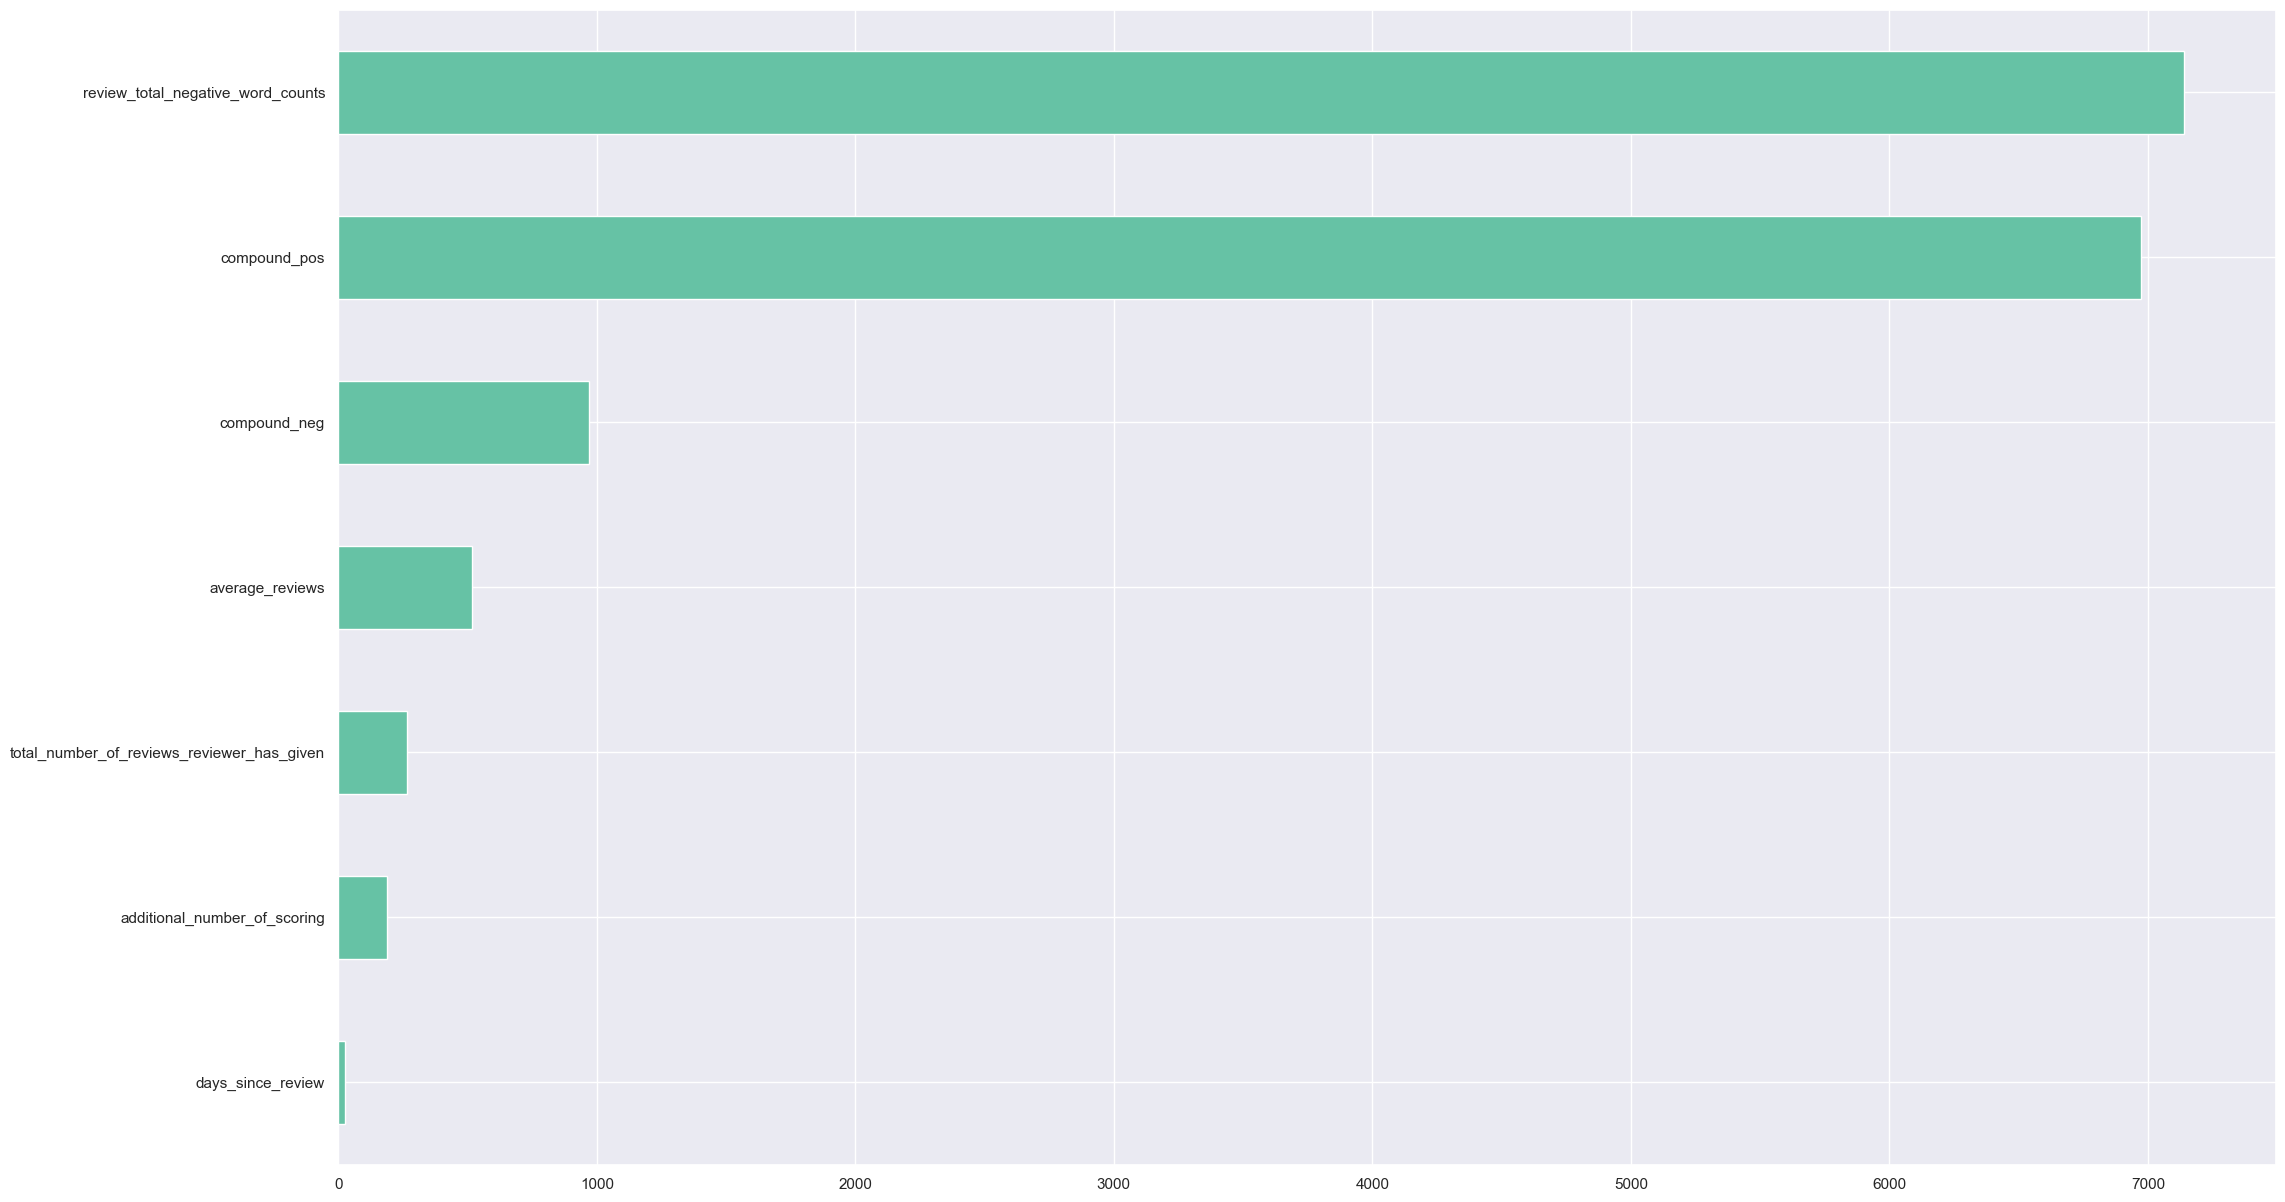

In [178]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Наименее значимым является признак days_since_review, тоже удалим его

In [179]:
data = data.drop('days_since_review', axis=1)

# Обучение модели

Переходим к самой волнительной, финальной части: обучение модели и вычесление метрик.

In [180]:
# Для начала разбиваем датасет на части, необходимые для оценки признаков
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [181]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [182]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 22), (386803, 22), (386803, 21), (309442, 21), (77361, 21))

In [183]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [184]:
# Создаём модель 
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [185]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


In [186]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических. 
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12737061054870386


Полученный результат метрики MAPE = 12.74%

<AxesSubplot: >

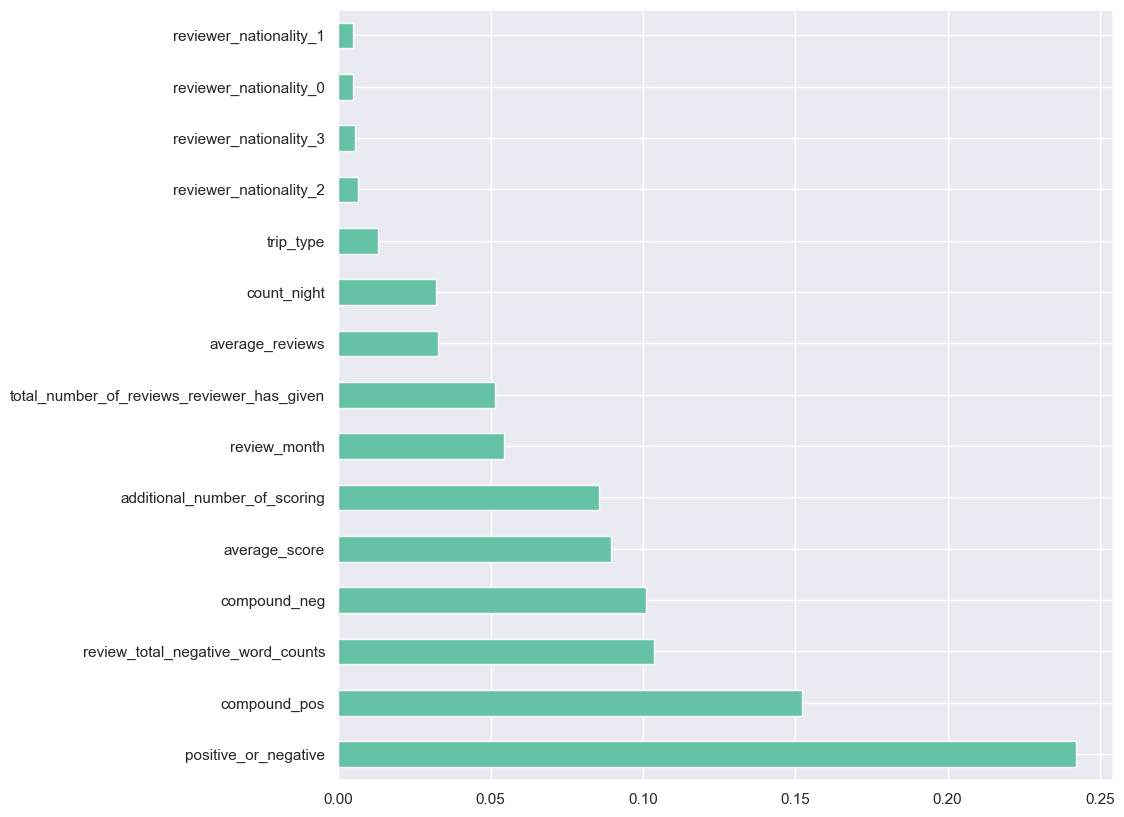

In [187]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Наиболейшее влияние на модель оказывают признаки, связанные с отзывами, что очень логично: является ли он положительным или отрицательным,  числом слов в этом отзыве, его оценкой. Также для модели важны такие признаки, как месяц, в котором был написан отзыв, и количество ночей, что говорит о том, что проделанная работа с категориальными признаками была полезной, и такая работа позволяет улучшить качество модели.

In [188]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,city_Barcelona,city_London,city_Vienna,country_Austria,country_Kingdom,...,average_reviews,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,trip_type,count_night,positive_or_negative,compound_pos,compound_neg
892,188,9.1,2,8,0.0,0,0,0,0,0,...,9.194162,0,0,1,0,1,4,1,0.7650,0.0000
99254,293,9.1,0,2,0.0,0,0,0,0,0,...,10.756853,0,1,1,0,1,3,1,0.8750,-0.7096
100808,1444,7.8,10,1,0.0,0,1,0,0,1,...,9.347544,1,1,1,1,3,2,0,0.0000,-0.6124
45372,205,8.1,0,7,0.0,0,0,0,0,0,...,5.173299,0,0,0,0,1,3,1,0.8874,-0.7096
47895,311,8.3,0,20,0.0,0,0,0,0,0,...,8.034796,1,1,0,0,2,2,1,0.9325,-0.7096
13455,2682,7.1,39,1,0.0,0,1,0,0,1,...,5.173299,0,0,0,0,1,1,0,0.5106,-0.2960
1132,704,8.8,22,2,0.0,0,1,0,0,1,...,5.173299,0,0,0,0,1,1,0,0.2666,0.5267
22564,740,7.4,6,16,0.0,0,0,0,0,0,...,8.539521,1,0,0,0,1,1,1,0.9466,0.3724
36085,211,8.9,22,4,0.0,1,0,0,0,0,...,5.173299,0,0,0,0,1,3,1,0.8967,0.6249
102843,170,8.9,29,1,0.0,1,0,0,0,0,...,5.173299,0,0,0,0,1,4,0,0.8910,-0.2732


In [189]:
#Делаем предсказание по данной в задании выборке
test_data = test_data.drop(['reviewer_score'], axis=1)

In [190]:
sample_submission

,reviewer_score,id
0,8.541,488440
1,7.745,274649
2,8.765,374688
3,9.680,404352
4,9.646,451596
...,...,...
128930,8.637,495812
128931,9.273,315577
128932,7.475,511968
128933,9.626,303386


In [191]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


In [192]:
predict_submission

array([8.541, 7.745, 8.765, ..., 7.475, 9.626, 6.866])

In [193]:
list(sample_submission)

['reviewer_score', 'id']

In [194]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.541,488440
1,7.745,274649
2,8.765,374688
3,9.680,404352
4,9.646,451596
5,8.909,302161
6,7.579,317079
7,7.056,13963
8,8.466,159785
9,7.195,195089
